In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/MQBI04_L15/BaiDuMarTechChallenge/")

In [3]:
import calendar
# import datetime as dt
from datetime import datetime, date, timedelta

import gc
import numpy as np
import pandas as pd

import missingno as msno
import seaborn as sns
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import roc_auc_score, accuracy_score
import lightgbm as lgb


sns.set_context('notebook')
sns.set_style('darkgrid')
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

# 准备数据
## 加载数据集

In [4]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("submission.csv")

df_train.shape, df_test.shape

((2306871, 29), (1585986, 2))

In [5]:
df_train.head(2)

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,order_detail_status,order_detail_goods_num,order_detail_amount,order_detail_payment,order_detail_discount,customer_province,customer_city,member_id,customer_id,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
0,1000000,1000000,1.0,239.9,96.9,0.0,2012-11-01 00:10:56,6,1.0,0.0,6.0,1.0,96.9,96.9,143.0,北京,北京市,0.0,1000000,NaN,NaN,NaN,998,998,54.909289,1.0,0.0,2014-10-25 11:08:07,2014-11-01 11:08:07
1,1001530,1001327,2.0,288.0,96.9,0.0,2013-08-31 23:14:42,6,2.0,0.0,6.0,1.0,0.0,0.0,99.0,内蒙古自治区,鄂尔多斯市,0.0,1001324,NaN,NaN,NaN,1953,1953,45.961352,0.0,1.0,2013-08-28 17:27:50,2013-09-01 00:38:17


In [6]:
df_test.head(2)

,customer_id,result
0,1000000,0
1,1000014,0


In [7]:
# 确定测试集中用户id是否在训练集用户id中
(df_test['customer_id'].isin(df_train['customer_id'].unique())).sum()

1585986

In [8]:
# 训练集用户id数量和测试集用户id数量相同
df_train['customer_id'].nunique(), df_test['customer_id'].nunique()

(1585986, 1585986)

可以确定测试集中要预测的用户就是训练集中的所有用户。

## 处理缺失值

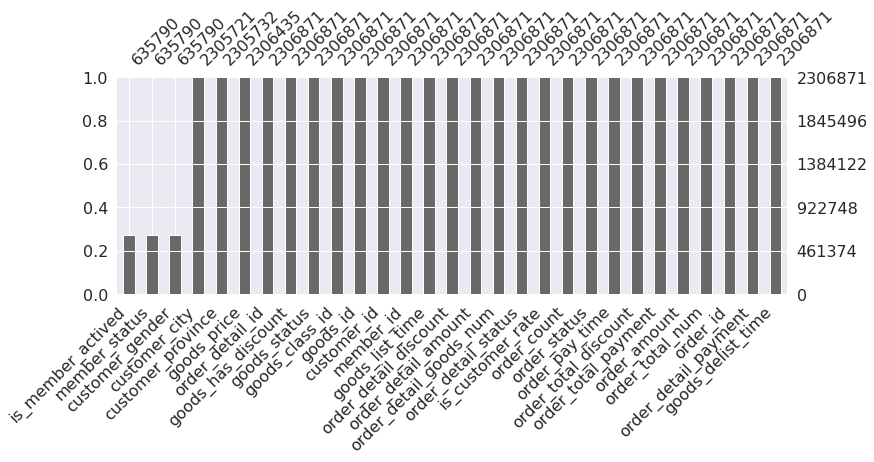

In [9]:
msno.bar(df_train, figsize=(12, 4),sort='ascending')

In [10]:
# 会员状态: 1正常，2冻结，3已删除
df_train['member_status'].value_counts()

1.0    635790
Name: member_status, dtype: int64

In [11]:
# 会员是否激活：0没有激活，1已激活
df_train['is_member_actived'].value_counts()

1.0    635790
Name: is_member_actived, dtype: int64

In [12]:
# 性别：0未知，1男，2女
df_train['customer_gender'].value_counts()

0.0    603970
2.0     18468
1.0     13352
Name: customer_gender, dtype: int64

In [13]:
MISS_COLS = [
    'customer_gender', 'member_status', 'is_member_actived', 'goods_price',
    'customer_province', 'customer_city'
]

# 使用0填充数值列缺失值，使用unknown填充字符串列
df_train[MISS_COLS[:-2]] = df_train[MISS_COLS[:-2]].fillna(0)
df_train[MISS_COLS[-2:]] = df_train[MISS_COLS[-2:]].fillna('unknown')

In [14]:
# 除了id和地址特征外，其他类别特征
CATE_COLS = [
    'goods_has_discount', 'goods_status', 'is_member_actived', 'member_status',
    'customer_gender', 'order_detail_status', 'is_customer_rate',
    'order_status', 
]

# 连续值特征
DENSE_COLS = [
    'goods_price', 'order_detail_discount', 'order_detail_payment',
    'order_detail_amount', 'order_detail_good_num', 'order_count',
    'order_total_discount', 'order_total_payment', 'order_amount',
    'order_total_num'
]


ID_COLS = df_train.columns[df_train.columns.str.endswith("_id")].to_list()

ADDRESS_COLS = ['customer_province', 'customer_city']

# 付款时间、商品最新上架时间、商品最新下架时间
DATE_COLS = ['order_pay_time', 'goods_list_time', 'goods_delist_time']

len(CATE_COLS) + len(DENSE_COLS) + len(ID_COLS) + len(ADDRESS_COLS) + len(DATE_COLS)

29

## 降低内存
通过选择较小的数据类型属性来减小数据集的大小

In [15]:
def cal_memory(df):
    """检查内存"""
    mem = df.memory_usage(index=True).sum()
    mb_usage = mem / 1024 ** 2
    print(f"数据集所占内存: {mb_usage:.2f}MB")
    


In [16]:
cal_memory(df_train)
cal_memory(df_test)

数据集所占内存: 510.40MB
数据集所占内存: 24.20MB


In [17]:
def reduce_mem_usage(df):
    """通过选择较小的数据类型属性来减小数据集的大小"""
    props = df.copy()
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()

            # 测试是否可以把该列数值类型修改为整数
            asint = props[col].astype(np.int64)
            result = (props[col] - asint).sum()

            if result > -0.01 and result < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:  # 非负数的整数修改为无符号整型
                    if mx < np.iinfo(np.uint8).max:  # uint8的上限
                        props[col] = props[col].astype(np.uint8)
                    elif mx < np.iinfo(np.uint16).max:  # uint16的上限
                        props[col] = props[col].astype(np.uint16)
                    elif mx < np.iinfo(np.uint32).max:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:  # 包含负数的整数，修改为有符号整型
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(
                            np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(
                            np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(
                            np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(
                            np.int64).max:
                        props[col] = props[col].astype(np.int64)

            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)

    return props

In [18]:
df_train = reduce_mem_usage(df_train)

print("选择较小的数据类型属性后：")
cal_memory(df_train)

选择较小的数据类型属性后：
数据集所占内存: 228.80MB


## 解析日期列

In [19]:
# 解析为datetime
for f in DATE_COLS:
    df_train[f] = pd.to_datetime(df_train[f], format="%Y-%m-%d")

In [20]:
# 最早下单时间，最晚下单时间
df_train['order_pay_time'].min(), df_train['order_pay_time'].max()

(Timestamp('2012-11-01 00:00:07'), Timestamp('2013-08-31 23:59:59'))

预测的是2013年9月所有用户是否购买。只有1-8月以及11月12月的10个月的订单数据，没有9月和10月数据。

# EDA

## 各省平均消费金额

In [21]:
# groups = df_train.groupby('customer_province')

# groups['order_amount'].mean().sort_values().plot(kind='bar',
#                                                  figsize=(12, 4),
#                                                  title="各省份平均消费金额",
#                                                  sort_columns=True)

## 各省份总销量统计

In [22]:
# groups['order_total_num'].sum().sort_values().plot(kind='bar',
#                                                    figsize=(12, 4),
#                                                    title="各省份总销量统计",
#                                                    sort_columns=True)

## 平均每月销售额

In [23]:
df_train['order_pay_date'] = df_train['order_pay_time'].dt.date
df_train['order_pay_year'] = df_train['order_pay_time'].dt.year
df_train['order_pay_month'] = df_train['order_pay_time'].dt.month
df_train['order_pay_day'] = df_train['order_pay_time'].dt.day

In [24]:
groupby_date = df_train.groupby('order_pay_month')

In [25]:
# groupby_date['order_amount'].mean().plot(
#     kind='bar', figsize=(12, 4), title="Average Monthly Sales", sort_columns=True)

## 每月下单用户数

In [26]:
# groupby_date['customer_id'].nunique().plot(kind='bar', figsize=(12, 4), title="每月下单用户数")

## 每月平均下单量

In [27]:
# groupby_date['order_amount'].count().plot(
#     kind='bar', figsize=(12, 4), title="每月平均下单量", sort_columns=True)

# 构建特征

In [28]:
from sklearn.preprocessing import LabelEncoder

## 地址列进行标签数值化

In [29]:
ADDRESS_COLS

['customer_province', 'customer_city']

In [30]:
for f in ADDRESS_COLS:
    df_train[f] = LabelEncoder().fit_transform(df_train[f].values)

df_train['customer_province'] = df_train[f].astype(np.uint8)
df_train['customer_city'] = df_train[f].astype(np.uint16)

## 构造时间滑窗特征

### 每日付款金额

In [31]:
df_train = df_train.set_index('order_pay_time')

In [32]:
df_train = df_train.sort_index()

In [33]:
# 只使用13年2月及其后的数据
df = df_train.loc['2013-02':]

In [34]:
# 将用户下单金额按天进行汇总
df_payment = df[['customer_id','order_pay_date','order_total_payment']]
df_payment

,customer_id,order_pay_date,order_total_payment
order_pay_time,,,
2013-02-01 00:00:10,2346052,2013-02-01,53.900002
2013-02-01 00:00:12,1309272,2013-02-01,89.900002
2013-02-01 00:00:24,2443988,2013-02-01,58.139999
2013-02-01 00:00:33,2447397,2013-02-01,109.900002
2013-02-01 00:00:33,1695371,2013-02-01,54.900002
...,...,...,...
2013-08-31 23:59:46,1910531,2013-08-31,187.600006
2013-08-31 23:59:46,1910531,2013-08-31,187.600006
2013-08-31 23:59:46,1910531,2013-08-31,187.600006


In [35]:
df_payment = df_payment.groupby(['order_pay_date','customer_id']).agg({'order_total_payment': ['sum']})
df_payment.head()

order_total_payment
                                           sum
order_pay_date customer_id                    
2013-02-01     1000434               79.900002
               1000997               79.900002
               1003010               79.900002
               1003873              371.399994
               1004890              183.800003

In [36]:
df_payment.columns = ['day_total_payment']
df_payment.reset_index(inplace=True)

In [37]:
df_payment.head()

,order_pay_date,customer_id,day_total_payment
0,2013-02-01,1000434,79.900002
1,2013-02-01,1000997,79.900002
2,2013-02-01,1003010,79.900002
3,2013-02-01,1003873,371.399994
4,2013-02-01,1004890,183.800003


In [38]:
df_payment = df_payment.set_index(["customer_id", "order_pay_date"])[["day_total_payment"]].unstack(level=-1).fillna(0)

df_payment.columns = df_payment.columns.get_level_values(1)

df_payment.head()

order_pay_date,2013-02-01,2013-02-02,2013-02-03,2013-02-04,2013-02-05,2013-02-06,2013-02-07,2013-02-08,2013-02-09,2013-02-10,2013-02-11,2013-02-12,2013-02-13,2013-02-14,2013-02-15,2013-02-16,2013-02-17,2013-02-18,2013-02-19,2013-02-20,2013-02-21,2013-02-22,2013-02-23,2013-02-24,2013-02-25,2013-02-26,2013-02-27,2013-02-28,2013-03-01,2013-03-02,2013-03-03,2013-03-04,2013-03-05,2013-03-06,2013-03-07,2013-03-08,2013-03-09,2013-03-10,2013-03-11,2013-03-12,...,2013-07-23,2013-07-24,2013-07-25,2013-07-26,2013-07-27,2013-07-28,2013-07-29,2013-07-30,2013-07-31,2013-08-01,2013-08-02,2013-08-03,2013-08-04,2013-08-05,2013-08-06,2013-08-07,2013-08-08,2013-08-09,2013-08-10,2013-08-11,2013-08-12,2013-08-13,2013-08-14,2013-08-15,2013-08-16,2013-08-17,2013-08-18,2013-08-19,2013-08-20,2013-08-21,2013-08-22,2013-08-23,2013-08-24,2013-08-25,2013-08-26,2013-08-27,2013-08-28,2013-08-29,2013-08-30,2013-08-31
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.900002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199.800003,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 每日购买数量

In [39]:
df_goods = df[['customer_id','order_pay_date','order_total_num']]
df_goods = df_goods.groupby(['order_pay_date','customer_id']).agg({'order_total_num': ['sum']})
df_goods.columns = ['day_total_num']

df_goods.reset_index(inplace=True)

df_goods = df_goods.set_index(
    ["customer_id", "order_pay_date"])[["day_total_num"]].unstack(level=-1).fillna(0)
df_goods.head()

day_total_num             ...                      
order_pay_date    2013-02-01 2013-02-02  ... 2013-08-30 2013-08-31
customer_id                              ...                      
1000014                  0.0        0.0  ...        0.0        0.0
1000034                  0.0        0.0  ...        0.0        0.0
1000046                  0.0        0.0  ...        0.0        0.0
1000069                  0.0        0.0  ...        0.0        0.0
1000105                  0.0        0.0  ...        0.0        0.0

[5 rows x 212 columns]

In [40]:
df_goods.columns.get_level_values(1)

DatetimeIndex(['2013-02-01', '2013-02-02', '2013-02-03', '2013-02-04',
               '2013-02-05', '2013-02-06', '2013-02-07', '2013-02-08',
               '2013-02-09', '2013-02-10',
               ...
               '2013-08-22', '2013-08-23', '2013-08-24', '2013-08-25',
               '2013-08-26', '2013-08-27', '2013-08-28', '2013-08-29',
               '2013-08-30', '2013-08-31'],
              dtype='datetime64[ns]', name='order_pay_date', length=212, freq=None)

In [41]:
df_goods.columns = df_goods.columns.get_level_values(1)
df_goods.head(2)

order_pay_date,2013-02-01,2013-02-02,2013-02-03,2013-02-04,2013-02-05,2013-02-06,2013-02-07,2013-02-08,2013-02-09,2013-02-10,2013-02-11,2013-02-12,2013-02-13,2013-02-14,2013-02-15,2013-02-16,2013-02-17,2013-02-18,2013-02-19,2013-02-20,2013-02-21,2013-02-22,2013-02-23,2013-02-24,2013-02-25,2013-02-26,2013-02-27,2013-02-28,2013-03-01,2013-03-02,2013-03-03,2013-03-04,2013-03-05,2013-03-06,2013-03-07,2013-03-08,2013-03-09,2013-03-10,2013-03-11,2013-03-12,...,2013-07-23,2013-07-24,2013-07-25,2013-07-26,2013-07-27,2013-07-28,2013-07-29,2013-07-30,2013-07-31,2013-08-01,2013-08-02,2013-08-03,2013-08-04,2013-08-05,2013-08-06,2013-08-07,2013-08-08,2013-08-09,2013-08-10,2013-08-11,2013-08-12,2013-08-13,2013-08-14,2013-08-15,2013-08-16,2013-08-17,2013-08-18,2013-08-19,2013-08-20,2013-08-21,2013-08-22,2013-08-23,2013-08-24,2013-08-25,2013-08-26,2013-08-27,2013-08-28,2013-08-29,2013-08-30,2013-08-31
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
df_goods.sum(1).describe()

count    685471.000000
mean          2.344128
std           7.942828
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1936.000000
dtype: float64

In [43]:
del df_train
gc.collect()

61

### 生成训练集和测试集

In [44]:
# 这是一个时间滑窗函数，获得dt之前minus天以来periods的dataframe，以便进一步计算
def get_timespan(df, dt, minus, periods, freq='D'):
    result = df[pd.date_range(dt - timedelta(days=minus),
                              periods=periods,
                              freq=freq)]
    return result

In [45]:
def prepare_dataset(df_payment, df_goods, t2018, is_train=True):
    X = {}
    # 整合用户id
    tmp = df_payment.reset_index()
    X['customer_id'] = tmp['customer_id']
    # 消费特征
    print('Preparing payment feature...')
    for i in [14, 30, 60, 91]:
        tmp = get_timespan(df_payment, t2018, i, i)
        # X['diff_%s_mean' % i] = tmp_1.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay' % i] = (tmp * np.power(0.9,
                               np.arange(i)[::-1])).sum(axis=1).values
        # X['mean_%s' % i] = tmp_1.mean(axis=1).values
        # X['median_%s' % i] = tmp.median(axis=1).values
        # X['min_%s' % i] = tmp_1.min(axis=1).values
        X['max_%s' % i] = tmp.max(axis=1).values
        # X['std_%s' % i] = tmp_1.std(axis=1).values
        X['sum_%s' % i] = tmp.sum(axis=1).values
    for i in [14, 30, 60, 91]:
        tmp = get_timespan(df_payment, t2018 + timedelta(days=-7), i, i)
        X['mean_%s_decay_2' %
          i] = (tmp * np.power(0.9,
                               np.arange(i)[::-1])).sum(axis=1).values
        # X['mean_%s_2' % i] = tmp_2.mean(axis=1).values
        # X['median_%s_2' % i] = tmp.median(axis=1).values
        # X['min_%s_2' % i] = tmp_2.min(axis=1).values
        X['max_%s_2' % i] = tmp.max(axis=1).values
        # X['std_%s_2' % i] = tmp_2.std(axis=1).values
    for i in [14, 30, 60, 91]:
        tmp = get_timespan(df_payment, t2018, i, i)
        X['has_sales_days_in_last_%s' % i] = (tmp != 0).sum(axis=1).values
        X['last_has_sales_day_in_last_%s' %
          i] = i - ((tmp != 0) * np.arange(i)).max(axis=1).values
        X['first_has_sales_day_in_last_%s' %
          i] = ((tmp != 0) * np.arange(i, 0, -1)).max(axis=1).values

    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['day_%s_2018' % i] = get_timespan(df_payment, t2018, i * 30,
                                            30).sum(axis=1).values
    # 商品数量特征，这里故意把时间和消费特征错开，提高时间滑窗的覆盖面
    print('Preparing num feature...')
    for i in [21, 49, 84]:
#     for i in [21]:
        tmp = get_timespan(df_goods, t2018, i, i)
        # X['goods_diff_%s_mean' % i] = tmp_1.diff(axis=1).mean(axis=1).values
        # X['goods_mean_%s_decay' % i] = (tmp_1 * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['goods_mean_%s' % i] = tmp.mean(axis=1).values
        # X['goods_median_%s' % i] = tmp.median(axis=1).values
        # X['goods_min_%s' % i] = tmp_1.min(axis=1).values
        X['goods_max_%s' % i] = tmp.max(axis=1).values
        # X['goods_std_%s' % i] = tmp_1.std(axis=1).values
        X['goods_sum_%s' % i] = tmp.sum(axis=1).values
    for i in [21, 49, 84]:
        tmp = get_timespan(df_goods, t2018 + timedelta(weeks=-1), i, i)
        # X['goods_diff_%s_mean_2' % i] = tmp_2.diff(axis=1).mean(axis=1).values
        # X['goods_mean_%s_decay_2' % i] = (tmp_2 * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['goods_mean_%s_2' % i] = tmp.mean(axis=1).values
        # X['goods_median_%s_2' % i] = tmp.median(axis=1).values
        # X['goods_min_%s_2' % i] = tmp_2.min(axis=1).values
        X['goods_max_%s_2' % i] = tmp.max(axis=1).values
        X['goods_sum_%s_2' % i] = tmp.sum(axis=1).values
    for i in [21, 49, 84]:
        tmp = get_timespan(df_goods, t2018, i, i)
        X['goods_has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
        X['goods_last_has_sales_day_in_last_%s' %
          i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
        X['goods_first_has_sales_day_in_last_%s' %
          i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values

    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['goods_day_%s_2018' % i] = get_timespan(df_goods, t2018, i * 28,
                                                  28).sum(axis=1).values

    X = pd.DataFrame(X)

    reduce_mem_usage(X)

    if is_train:
        # 这样转换之后，打标签直接用numpy切片就可以了
        # 当然这里前提是确认付款总额没有负数的问题
        X['label'] = df_goods[pd.date_range(t2018,
                                            periods=30)].max(axis=1).values
        X['label'][X['label'] > 0] = 1
        
    return X

In [46]:
num_days = 1
t2017 = date(2013, 7, 1)
X_l, y_l = [], []

for i in range(num_days):
    delta = timedelta(days=7 * i)
    # X_tmp, y_tmp = prepare_dataset(df_payment, df_goods, t2017 + delta)
    X_tmp = prepare_dataset(df_payment, df_goods, t2017 + delta)
    X_tmp = pd.concat([X_tmp], axis=1)

    X_l.append(X_tmp)
    # y_l.append(y_tmp)
    del X_tmp
    gc.collect()
    
X_train = pd.concat(X_l, axis=0)
# y_train = np.concatenate(y_l, axis=0)

del X_l, y_l

Preparing payment feature...
Preparing num feature...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
X_train.shape

(685471, 67)

In [48]:
X_train.to_csv('X_train.csv', index=False)
cal_memory(X_train)

数据集所占内存: 311.17MB


In [49]:
del X_train
gc.collect()

0

In [50]:
X_test = prepare_dataset(df_payment, df_goods, date(2013, 9, 1), is_train=False)
X_test = pd.concat([X_test], axis=1)

cal_memory(X_test)

Preparing payment feature...
Preparing num feature...
数据集所占内存: 305.94MB


In [51]:
X_test.head()

,customer_id,mean_14_decay,max_14,sum_14,mean_30_decay,max_30,sum_30,mean_60_decay,max_60,sum_60,mean_91_decay,max_91,sum_91,mean_14_decay_2,max_14_2,mean_30_decay_2,max_30_2,mean_60_decay_2,max_60_2,mean_91_decay_2,max_91_2,has_sales_days_in_last_14,last_has_sales_day_in_last_14,first_has_sales_day_in_last_14,has_sales_days_in_last_30,last_has_sales_day_in_last_30,first_has_sales_day_in_last_30,has_sales_days_in_last_60,last_has_sales_day_in_last_60,first_has_sales_day_in_last_60,has_sales_days_in_last_91,last_has_sales_day_in_last_91,first_has_sales_day_in_last_91,day_1_2018,day_2_2018,day_3_2018,goods_mean_21,goods_max_21,goods_sum_21,goods_mean_49,goods_max_49,goods_sum_49,goods_mean_84,goods_max_84,goods_sum_84,goods_mean_21_2,goods_max_21_2,goods_sum_21_2,goods_mean_49_2,goods_max_49_2,goods_sum_49_2,goods_mean_84_2,goods_max_84_2,goods_sum_84_2,goods_has_sales_days_in_last_21,goods_last_has_sales_day_in_last_21,goods_first_has_sales_day_in_last_21,goods_has_sales_days_in_last_49,goods_last_has_sales_day_in_last_49,goods_first_has_sales_day_in_last_49,goods_has_sales_days_in_last_84,goods_last_has_sales_day_in_last_84,goods_first_has_sales_day_in_last_84,goods_day_1_2018,goods_day_2_2018,goods_day_3_2018
0,1000014,0.0,0.0,0.0,3.501196,66.900002,66.900002,3.501196,66.900002,66.900002,3.501196,66.900002,66.900002,0.0,0.0,7.320131,66.900002,7.320131,66.900002,7.320131,66.900002,0,14,0,1,29,29,1,29,29,1,29,29,66.900002,0.000000,0.000000,0.0,0.0,0.0,0.020408,1.0,1.0,0.011905,1.0,1.0,0.0,0.0,0.0,0.020408,1.0,1.0,0.011905,1.0,1.0,0,21,0,1,29,29,1,29,29,0.0,1.0,0.0
1,1000034,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,14,0,0,30,0,0,60,0,0,91,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0,21,0,0,49,0,0,84,0,0.0,0.0,0.0
2,1000046,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005147,39.900002,39.900002,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.010762,39.900002,0,14,0,0,30,0,0,60,0,1,86,86,0.000000,0.000000,39.900002,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.011905,1.0,1.0,0,21,0,0,49,0,0,84,0,0.0,0.0,0.0
3,1000069,0.0,0.0,0.0,0.000000,0.000000,0.000000,2.285986,399.200012,399.200012,2.285986,399.200012,399.200012,0.0,0.0,0.000000,0.000000,4.779428,399.200012,4.779428,399.200012,0,14,0,0,30,0,1,50,50,1,50,50,0.000000,399.200012,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.154762,13.0,13.0,0.0,0.0,0.0,0.265306,13.0,13.0,0.154762,13.0,13.0,0,21,0,0,49,0,1,50,50,0.0,13.0,0.0
4,1000105,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.315646,98.900002,98.900002,1.315646,98.900002,98.900002,0.0,0.0,0.000000,0.000000,2.750690,98.900002,2.750690,98.900002,0,14,0,0,30,0,1,42,42,1,42,42,0.000000,98.900002,0.000000,0.0,0.0,0.0,0.020408,1.0,1.0,0.011905,1.0,1.0,0.0,0.0,0.0,0.020408,1.0,1.0,0.011905,1.0,1.0,0,21,0,1,42,42,1,42,42,0.0,1.0,0.0


In [52]:
X_test.to_csv('X_test.csv', index=False)

In [53]:
del X_test
gc.collect()

12

In [54]:
del df_payment
del df_goods
gc.collect()

0

### 保存数据

In [55]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')

In [56]:
X_train = X_train[['has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91','goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21_2', 'goods_mean_49_2', 'goods_max_49_2', 'goods_sum_49_2',
       'goods_mean_84_2', 'goods_max_84_2', 'goods_sum_84_2',
       'goods_has_sales_days_in_last_21',
       'goods_last_has_sales_day_in_last_21',
       'goods_first_has_sales_day_in_last_21',
       'goods_has_sales_days_in_last_49',
       'goods_last_has_sales_day_in_last_49',
       'goods_first_has_sales_day_in_last_49',
       'goods_has_sales_days_in_last_84',
       'goods_last_has_sales_day_in_last_84',
       'goods_first_has_sales_day_in_last_84', 'goods_day_1_2018',
       'goods_day_2_2018', 'goods_day_3_2018','label']]
       
X_test = X_test[['has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91','goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21_2', 'goods_mean_49_2', 'goods_max_49_2', 'goods_sum_49_2',
       'goods_mean_84_2', 'goods_max_84_2', 'goods_sum_84_2',
       'goods_has_sales_days_in_last_21',
       'goods_last_has_sales_day_in_last_21',
       'goods_first_has_sales_day_in_last_21',
       'goods_has_sales_days_in_last_49',
       'goods_last_has_sales_day_in_last_49',
       'goods_first_has_sales_day_in_last_49',
       'goods_has_sales_days_in_last_84',
       'goods_last_has_sales_day_in_last_84',
       'goods_first_has_sales_day_in_last_84', 'goods_day_1_2018',
       'goods_day_2_2018', 'goods_day_3_2018']]

In [57]:
X_train.shape, X_test.shape

((685471, 42), (685471, 41))

In [58]:
X_train.head(2)

,has_sales_days_in_last_14,last_has_sales_day_in_last_14,first_has_sales_day_in_last_14,has_sales_days_in_last_30,last_has_sales_day_in_last_30,first_has_sales_day_in_last_30,has_sales_days_in_last_60,last_has_sales_day_in_last_60,first_has_sales_day_in_last_60,has_sales_days_in_last_91,last_has_sales_day_in_last_91,goods_mean_21,goods_max_21,goods_sum_21,goods_mean_49,goods_max_49,goods_sum_49,goods_mean_84,goods_max_84,goods_sum_84,goods_mean_21_2,goods_max_21_2,goods_sum_21_2,goods_mean_49_2,goods_max_49_2,goods_sum_49_2,goods_mean_84_2,goods_max_84_2,goods_sum_84_2,goods_has_sales_days_in_last_21,goods_last_has_sales_day_in_last_21,goods_first_has_sales_day_in_last_21,goods_has_sales_days_in_last_49,goods_last_has_sales_day_in_last_49,goods_first_has_sales_day_in_last_49,goods_has_sales_days_in_last_84,goods_last_has_sales_day_in_last_84,goods_first_has_sales_day_in_last_84,goods_day_1_2018,goods_day_2_2018,goods_day_3_2018,label
0,0,14,0,0,30,0,0,60,0,0,91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,21,0,0,49,0,0,84,0,0.0,0.0,0.0,0.0
1,0,14,0,0,30,0,0,60,0,0,91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,21,0,0,49,0,0,84,0,0.0,0.0,0.0,0.0


In [59]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

cal_memory(X_train)
cal_memory(X_test)

数据集所占内存: 219.65MB
数据集所占内存: 214.42MB


# 数据预处理
## 数据归一化

In [60]:
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [61]:
# 前面标签也被归一化了，还原
X_train['label'][X_train['label'] > 0] = 1

## 拆分数据集

In [62]:
# 数据分割
def load_data(df,istrain):
    # data = np.fromfile(datafile)
    data = df.copy()

    feature_num = len(data.columns)
    # 将原始数据进行Reshape
    data = np.array(data)
    data = data.reshape([-1, feature_num])
    
    # 训练集和测试集的划分比例
    ratio = 0.8
    if istrain == True:
        offset = int(data.shape[0] * ratio)
        training_data = data[:offset]
        test_data = data[offset:]
    else:
        training_data = data
        test_data = None

    return training_data, test_data

In [63]:
# 加载处理后的数据
train_data, val_data = load_data(X_train, True)
print('train set done.')

pre_data, none = load_data(X_test, False)
print('test set done.')


train set done.
test set done.


In [64]:
train_data.shape, val_data.shape

((548376, 42), (137095, 42))

## 转张量

In [65]:
# 指定训练集、验证集和测试集
y_train = train_data[:, -1]
x_train = train_data[:, :-1]

Y_val = val_data[:, -1]
x_val = val_data[:, :-1]

x_test = pre_data.copy()

In [66]:
# # 数组转为张量，并修改数据类型
# y_train = torch.from_numpy(y_train).type(torch.LongTensor)
# x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
# y_val = torch.from_numpy(Y_val).type(torch.LongTensor)
# x_val = torch.from_numpy(x_val).type(torch.FloatTensor)

# x_test = torch.from_numpy(pre_data).type(torch.FloatTensor)

## 分批打包

# 神经网络训练及预测
## 构建多层神经网络

In [67]:
def seed_everything(seed=30):
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.determindistic=True
    # torch.backends.cudnn.benchmark = True
    
seed_everything(seed=30)

```
self.linear1 = nn.Linear(in_features=41, out_features=128) 
self.relu = nn.ReLU()
self.linear2 = nn.Linear(128, 128)
self.relu = nn.ReLU()
self.linear3 =  nn.Linear(128, 2)
```

## Lightgbm

In [68]:
model = lgb.LGBMClassifier(class_weight="balanced")

model.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [69]:
y_val_pred = model.predict(x_val)
y_val_pro = model.predict_proba(x_val)[:, 1]

print("在验证集上的准确率:{:.2f}%".format(accuracy_score(Y_val, y_val_pred) * 100))
print("在验证集上的AUC:{:.2f}%".format(roc_auc_score(Y_val, y_val_pro) * 100))

在验证集上的准确率:48.68%
在验证集上的AUC:65.63%


## 预测

In [70]:
sub_preds = model.predict(x_test)

In [71]:
(sub_preds == 1).sum()

352906

# 保存预测结果

In [72]:
sub = pd.read_csv("X_test.csv", usecols=['customer_id'])
df_test = pd.read_csv("submission.csv", usecols=['customer_id'])

In [73]:
df_preds = pd.DataFrame({
    "customer_id": sub['customer_id'],
    "result": sub_preds
})

In [74]:
df_test = df_test[['customer_id']].merge(df_preds, on='customer_id', how='left')
df_test = df_test.fillna(0)
df_test['result'] = df_test['result'].astype('int')

In [75]:
df_test['result'].value_counts()

0    1233080
1     352906
Name: result, dtype: int64

In [76]:
df_test.to_csv('submission.csv', index=False)

# 总结：

- 失策了，留出来准备这个作业的时间太短。没想到这个比赛需要自己制作训练集和用于预测的测试集，没做出满意的成绩。
- merge之后，DataFrame的数据类型会恢复为默认的64。